# Code for: a simple example

In [157]:
using Plots, Measures

include("../src/LoadData.jl")
include("../src/PMMH.jl")
include("../src/MarginalPosterior.jl")
include("../src/Support.jl")

# Load data
Y = loadData("NZCOVID");

In [158]:
function simpleModel(σ, Y::DataFrame, opts::Dict)

    # Extract frequently used options
    T = opts["T"] # Number of time-steps
    N = opts["N"] # Number of particles
    L = opts["L"] # Fixed-lag resampling length
    ω = opts["ω"] # Serial interval

    # Initialise output matrices
    R = zeros(N, T) # Reproduction number
    C = zeros(N, T) # Predictive cases (if enabled)
    W = zeros(N, T)

    # Sample from the initial distribution
    R[:,1] = rand(opts["pR0"], N)

    # Run the filter
    for tt = 2:T

        # Project according to the state-space model
        R[:,tt] = exp.(rand.(Normal.(log.(R[:,tt-1]), σ)))

        # Calculate the force-of-infection term
        Λ = sum(Y.Ct[tt-1:-1:1] .* ω[1:tt-1])

        # Weight according to the observation model
        W[:,tt] = pdf.(Poisson.(Λ * R[:,tt]), Y.Ct[tt])

        # Resample
        inds = wsample(1:N, W[:,tt], N; replace=true)
        R[:, max(tt-L,1):tt] = R[inds, max(tt-L,1):tt]

    end

    # Calculate predictive cases (if enabled)
    if opts["predictiveValues"]
        for tt = 1:T
            Λ = sum(Y.Ct[tt:-1:1] .* ω[1:tt])
            C[:,tt] = rand.(Poisson.(Λ * R[:,tt]))
        end
    end

    # Store output as a three-dimensional array
    X = zeros(N, T, 2)
    X[:,:,1] = R
    X[:,:,2] = C

    # Return
    return(X, W)

end

simpleModel (generic function with 1 method)

In [159]:
opts = Dict(

    # Bootstrap filter options
    "T" => size(Y, 1), # Number of time-steps
    "N" => 1000, # Number of particles
    "L" => 50, # Fixed-lag resampling length
    "ω" => pdf.(Gamma(2.36, 2.74), 1:100), # Serial interval
    "pR0" => Uniform(0, 10), # Prior on Rt at t = 0
    "predictiveValues" => false, # Whether to calculate predictive cases

    # PMMH options
    "nChains" => 3, # Number of chains
    "chunkSize" => 100, # Number of iterations
    "maxChunks" => 50, # Maximum number of chunks
    "maxRhat" => 1.05,  # Stopping criterion: maximum Rhat value
    "minESS" => 100, # Stopping criterion: minimum effective sample size
    "showChunkProgress" => true, # Whether to show progress of each chunk
    "propStdDevInit" => [0.1], # Initial proposal standard deviation (this is adaptively fit)
    "paramPriors" => [Uniform(0, 1)],
    "initialParamSamplers" => [Uniform(0.1, 0.3)],
    "paramLimits" => [(0, 1)],
    "paramNames" => ["σ"],

    # Marginal posterior options
    "posteriorNumberOfParticles" => 1000,
    "posteriorParamSamples" => 100

);

In [160]:
(θ, diag) = PMMH(simpleModel, Y, opts; verbose=false)
Chains(θ, opts["paramNames"])

Chains MCMC chain (200×1×3 Array{Float64, 3}):

Iterations        = 1:1:200
Number of chains  = 3
Samples per chain = 200
parameters        = σ

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           σ    0.2433    0.0509     0.0021    0.0050   105.2848    1.0117

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.1602    0.2047    0.2353    0.2743    0.3552


In [161]:
opts["predictiveValues"] = true
X = marginalPosterior(simpleModel, θ, Y, opts)
(mR, medR, lR, uR) = processResults(X[:,:,1])
(mC, medC, lC, uC) = processResults(X[:,:,2])

([0.20431, 0.33257, 0.38238, 0.37434, 0.34426, 0.47844, 0.5315, 0.86501, 1.26883, 1.41383  …  0.06666, 0.05426, 0.0431, 0.03491, 0.02905, 0.02292, 0.01792, 0.01388, 0.01127, 0.00892], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 5.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])

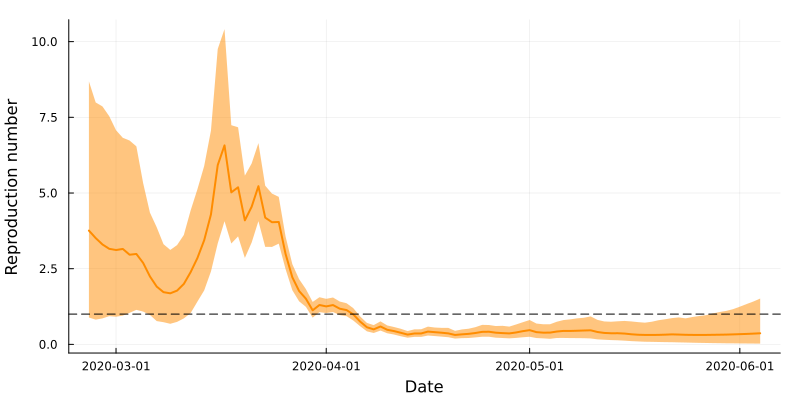

In [162]:
# Plot Rt posterior
pltR = plot(xlabel="Date", ylabel="Reproduction number", size=(800,400), margins=3mm)
pltR = plot!(Y.date, mR, ribbon=(mR-lR, uR-mR), color=:darkorange, label=false, linewidth=2)
pltR = hline!([1], label=false, color=:black, line=:dash)

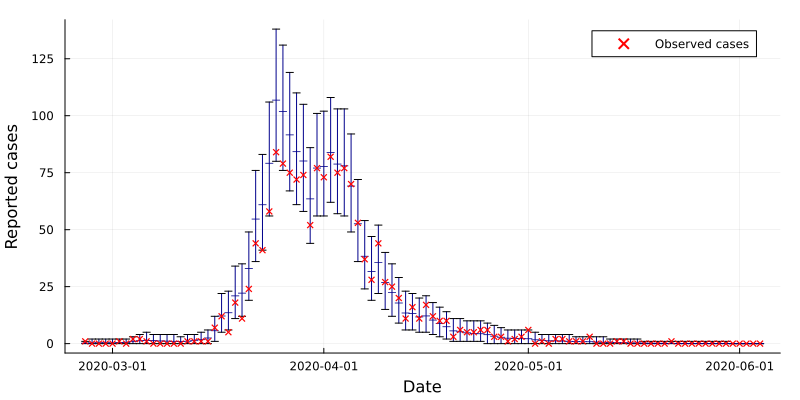

In [163]:
# Plot Ct posterior
pltC = plot(xlabel="Date", ylabel="Reported cases", size=(800,400), margins=3mm)
pltC = scatter!(Y.date, mC, errorbar=(mC-lC, uC-mC), color=:darkblue, lc=:darkblue, markershape=:hline, label=false)
pltC = scatter!(Y.date, Y.Ct, color=:red, label="Observed cases", markershape=:x, markersize=3, markerstrokewidth=1.5)

In [164]:
# Run model until t = 40 and use L = 40 (so we sample from the full marginal posterior for days 10 to 50)
opts2 = deepcopy(opts)
opts2["T"] = 40
opts2["L"] = 40
Y2 = Y[1:opts2["T"],:]
X2 = marginalPosterior(simpleModel, θ, Y2, opts2)

# Specify trajectory indices to use
traj_inds = 11:40;

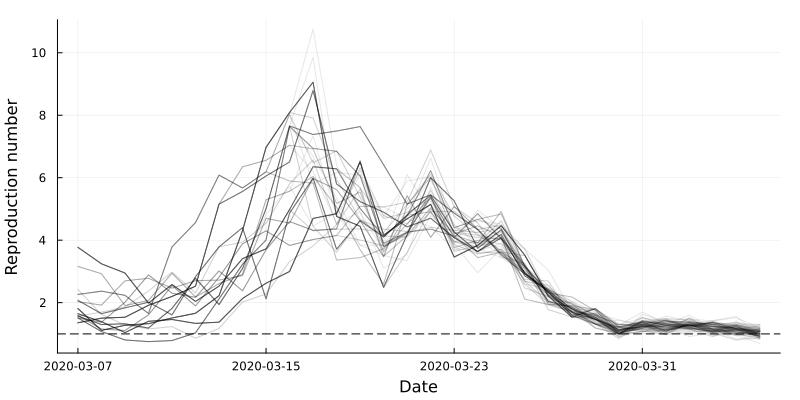

In [165]:
# Plot trajectories
pltR_traj = plot(xlabel="Date", ylabel="Reproduction number", size=(800,400), margins=3mm)
pltTrajs = plot!(Y2.date[traj_inds], X2[1:100,traj_inds,1]', color=:black, alpha=0.1, label=false)
pltTrajs = hline!([1], label=false, color=:black, line=:dash)

In [166]:
# Find samples of max Rt values
maxvals = maximum(X2[:,traj_inds,1], dims=2)[1:end]
(mean_max, lower_max, upper_max) = (mean(maxvals), quantile(maxvals, 0.025), quantile(maxvals, 0.975))
println("Peak Rt = $(round(mean_max, digits=1)) (95% CI: $(round(lower_max, digits=1)), $(round(upper_max, digits=1)))")

Peak Rt = 6.8 (95% CI: 5.0, 9.8)


In [167]:
# Find the timing of max values of Rt
maxInds = [findfirst(X2[ii,traj_inds,1] .== maxvals[ii]) for ii in 1:size(X2,1)]
maxDates = Y2.date[traj_inds][maxInds]
inds = Int.([median(maxInds), quantile(maxInds, 0.025), quantile(maxInds, 0.975)])
(med_date, lower_date, upper_date) = Y2.date[traj_inds][inds]
println("Peak Rt date = $(med_date) (95% CI: $(lower_date), $(upper_date))")


Peak Rt date = 2020-03-17 (95% CI: 2020-03-16, 2020-03-22)


In [168]:
# Create matrix of counts for heatmap
Rt_grid = 0:0.5:18
date_grid = minimum(maxDates):Day(1):maximum(maxDates)
Z = zeros(length(Rt_grid), length(date_grid))

# Round down maxvals to 0.5
maxvals_rounded = 0.5 .* floor.(maxvals / 0.5)

# Fetch counts
for ii = 1:length(Rt_grid)
    for jj = 1:length(date_grid)
        Z[ii,jj] = sum((maxvals_rounded .== Rt_grid[ii]) .& (maxDates .== date_grid[jj]))
    end
end


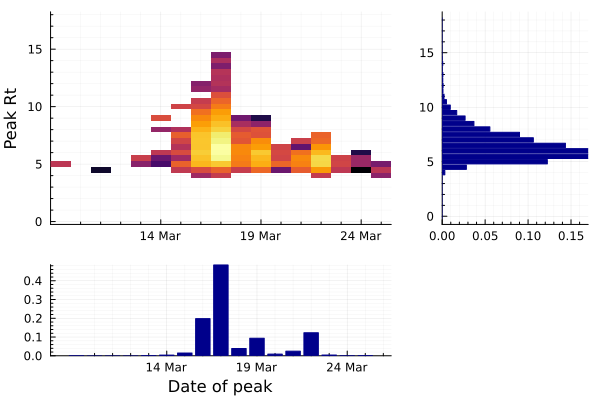

In [169]:
dateticks = (Date.(["2020-03-14", "2020-03-19", "2020-03-24"]), ["14 Mar", "19 Mar", "24 Mar"])

# Plot heatmap and 1D posteriors
joint = heatmap(date_grid, Rt_grid, log.(Z/sum(Z)), ylabel="Peak Rt", legend=false, xticks=dateticks, minorgrid=true)
datemarg = bar(date_grid, sum(Z, dims=1)[1,:]/size(X2, 1), xlabel="Date of peak", color=:darkblue, linecolor=:darkblue, legend=false, xticks=dateticks, minorgrid=true)
Rtmarg = bar(Rt_grid, sum(Z, dims=2)[:,1]/size(X2, 1), color=:darkblue, linecolor=:darkblue, legend=false, orientation=:horizontal, xlims=(0, 0.17), minorgrid=true)

layout = grid(2, 2, heights=[0.7, 0.3], widths=[0.7, 0.3])
pltJointPosterior = plot(joint, Rtmarg, datemarg, plot(framestyle=:none),layout=layout)


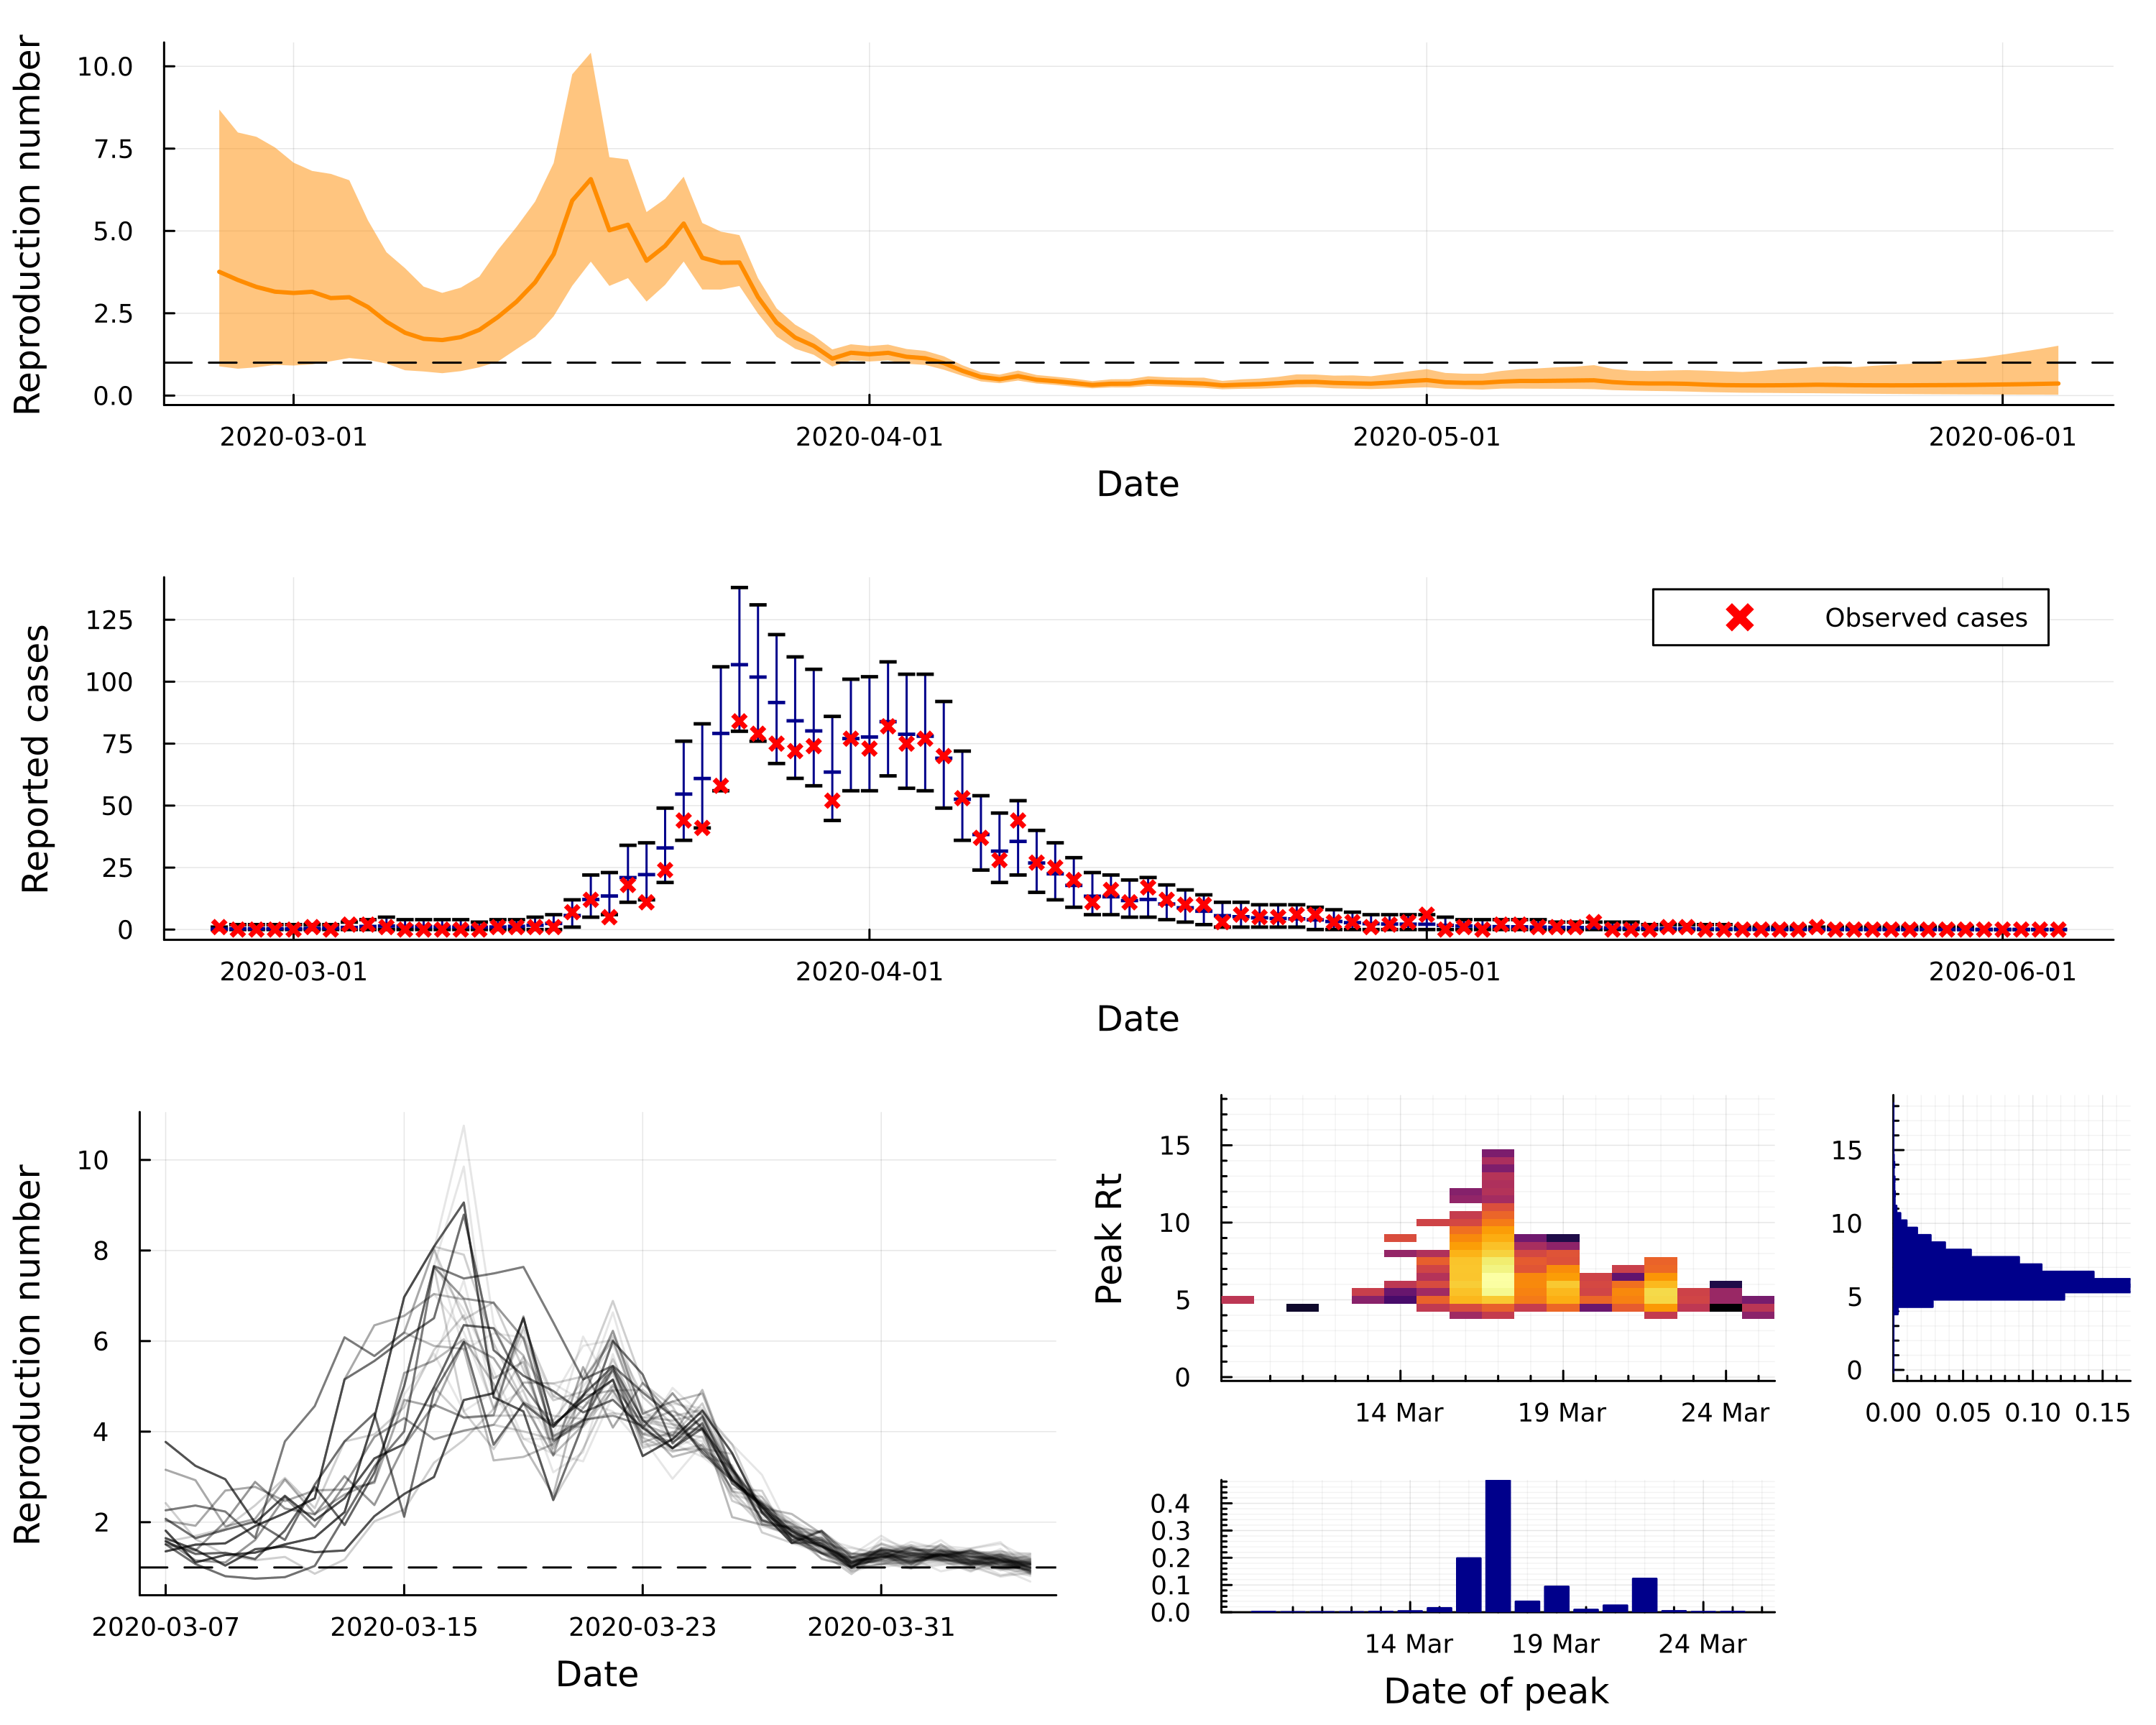

In [171]:
# Combine all plots
pltUpper = plot(pltR, pltC, layout=(2,1))
pltLower = plot(pltTrajs, pltJointPosterior, layout=(1,2))
plt = plot(pltUpper, pltLower, layout=grid(2,1,heights=[0.65, 0.35]), size=(1000,800), dpi=300)
png("figures/simplemodel.png")
plt